In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# Acknowledgement to
# https://github.com/kuangliu/pytorch-cifar,
# https://github.com/BIGBALLON/CIFAR-ZOO,


''' Swish activation '''
class Swish(nn.Module): # Swish(x) = x∗σ(x)
    def __init__(self):
        super().__init__()

    def forward(self, input):
        return input * torch.sigmoid(input)


''' MLP '''
class MLP(nn.Module):
    def __init__(self, channel, num_classes):
        super(MLP, self).__init__()
        self.fc_1 = nn.Linear(28*28*1 if channel==1 else 32*32*3, 128)
        self.fc_2 = nn.Linear(128, 128)
        self.fc_3 = nn.Linear(128, num_classes)

    def forward(self, x):
        out = x.view(x.size(0), -1)
        out = F.relu(self.fc_1(out))
        out = F.relu(self.fc_2(out))
        out = self.fc_3(out)
        return out



''' ConvNet '''
class ConvNet(nn.Module):
    def __init__(self, channel, num_classes, net_width, net_depth, net_act, net_norm, net_pooling, im_size = (32,32)):
        super(ConvNet, self).__init__()

        self.features, shape_feat = self._make_layers(channel, net_width, net_depth, net_norm, net_act, net_pooling, im_size)
        num_feat = shape_feat[0]*shape_feat[1]*shape_feat[2]
        self.classifier = nn.Linear(num_feat, num_classes)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def embed(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        return out

    def _get_activation(self, net_act):
        if net_act == 'sigmoid':
            return nn.Sigmoid()
        elif net_act == 'relu':
            return nn.ReLU(inplace=True)
        elif net_act == 'leakyrelu':
            return nn.LeakyReLU(negative_slope=0.01)
        elif net_act == 'swish':
            return Swish()
        else:
            exit('unknown activation function: %s'%net_act)

    def _get_pooling(self, net_pooling):
        if net_pooling == 'maxpooling':
            return nn.MaxPool2d(kernel_size=2, stride=2)
        elif net_pooling == 'avgpooling':
            return nn.AvgPool2d(kernel_size=2, stride=2)
        elif net_pooling == 'none':
            return None
        else:
            exit('unknown net_pooling: %s'%net_pooling)

    def _get_normlayer(self, net_norm, shape_feat):
        # shape_feat = (c*h*w)
        if net_norm == 'batchnorm':
            return nn.BatchNorm2d(shape_feat[0], affine=True)
        elif net_norm == 'layernorm':
            return nn.LayerNorm(shape_feat, elementwise_affine=True)
        elif net_norm == 'instancenorm':
            return nn.GroupNorm(shape_feat[0], shape_feat[0], affine=True)
        elif net_norm == 'groupnorm':
            return nn.GroupNorm(4, shape_feat[0], affine=True)
        elif net_norm == 'none':
            return None
        else:
            exit('unknown net_norm: %s'%net_norm)

    def _make_layers(self, channel, net_width, net_depth, net_norm, net_act, net_pooling, im_size):
        layers = []
        in_channels = channel
        if im_size[0] == 28:
            im_size = (32, 32)
        shape_feat = [in_channels, im_size[0], im_size[1]]
        for d in range(net_depth):
            layers += [nn.Conv2d(in_channels, net_width, kernel_size=3, padding=3 if channel == 1 and d == 0 else 1)]
            shape_feat[0] = net_width
            if net_norm != 'none':
                layers += [self._get_normlayer(net_norm, shape_feat)]
            layers += [self._get_activation(net_act)]
            in_channels = net_width
            if net_pooling != 'none':
                layers += [self._get_pooling(net_pooling)]
                shape_feat[1] //= 2
                shape_feat[2] //= 2

        return nn.Sequential(*layers), shape_feat



''' LeNet '''
class LeNet(nn.Module):
    def __init__(self, channel, num_classes):
        super(LeNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(channel, 6, kernel_size=5, padding=2 if channel==1 else 0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc_1 = nn.Linear(16 * 5 * 5, 120)
        self.fc_2 = nn.Linear(120, 84)
        self.fc_3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc_1(x))
        x = F.relu(self.fc_2(x))
        x = self.fc_3(x)
        return x



''' AlexNet '''
class AlexNet(nn.Module):
    def __init__(self, channel, num_classes):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(channel, 128, kernel_size=5, stride=1, padding=4 if channel==1 else 2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc = nn.Linear(192 * 4 * 4, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def embed(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return x


''' AlexNetBN '''
class AlexNetBN(nn.Module):
    def __init__(self, channel, num_classes):
        super(AlexNetBN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(channel, 128, kernel_size=5, stride=1, padding=4 if channel==1 else 2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 192, kernel_size=5, padding=2),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc = nn.Linear(192 * 4 * 4, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def embed(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return x


''' VGG '''
cfg_vgg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}
class VGG(nn.Module):
    def __init__(self, vgg_name, channel, num_classes, norm='instancenorm'):
        super(VGG, self).__init__()
        self.channel = channel
        self.features = self._make_layers(cfg_vgg[vgg_name], norm)
        self.classifier = nn.Linear(512 if vgg_name != 'VGGS' else 128, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def embed(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return x

    def _make_layers(self, cfg, norm):
        layers = []
        in_channels = self.channel
        for ic, x in enumerate(cfg):
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=3 if self.channel==1 and ic==0 else 1),
                           nn.GroupNorm(x, x, affine=True) if norm=='instancenorm' else nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)


def VGG11(channel, num_classes):
    return VGG('VGG11', channel, num_classes)
def VGG11BN(channel, num_classes):
    return VGG('VGG11', channel, num_classes, norm='batchnorm')
def VGG13(channel, num_classes):
    return VGG('VGG13', channel, num_classes)
def VGG16(channel, num_classes):
    return VGG('VGG16', channel, num_classes)
def VGG19(channel, num_classes):
    return VGG('VGG19', channel, num_classes)


''' ResNet_AP '''
# The conv(stride=2) is replaced by conv(stride=1) + avgpool(kernel_size=2, stride=2)

class BasicBlock_AP(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, norm='instancenorm'):
        super(BasicBlock_AP, self).__init__()
        self.norm = norm
        self.stride = stride
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=1, padding=1, bias=False) # modification
        self.bn1 = nn.GroupNorm(planes, planes, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.GroupNorm(planes, planes, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=1, bias=False),
                nn.AvgPool2d(kernel_size=2, stride=2), # modification
                nn.GroupNorm(self.expansion * planes, self.expansion * planes, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        if self.stride != 1: # modification
            out = F.avg_pool2d(out, kernel_size=2, stride=2)
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck_AP(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, norm='instancenorm'):
        super(Bottleneck_AP, self).__init__()
        self.norm = norm
        self.stride = stride
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.GroupNorm(planes, planes, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False) # modification
        self.bn2 = nn.GroupNorm(planes, planes, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion * planes, kernel_size=1, bias=False)
        self.bn3 = nn.GroupNorm(self.expansion * planes, self.expansion * planes, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(self.expansion * planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=1, bias=False),
                nn.AvgPool2d(kernel_size=2, stride=2),  # modification
                nn.GroupNorm(self.expansion * planes, self.expansion * planes, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        if self.stride != 1: # modification
            out = F.avg_pool2d(out, kernel_size=2, stride=2)
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet_AP(nn.Module):
    def __init__(self, block, num_blocks, channel=3, num_classes=10, norm='instancenorm'):
        super(ResNet_AP, self).__init__()
        self.in_planes = 64
        self.norm = norm

        self.conv1 = nn.Conv2d(channel, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.GroupNorm(64, 64, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.classifier = nn.Linear(512 * block.expansion * 3 * 3 if channel==1 else 512 * block.expansion * 4 * 4, num_classes)  # modification

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride, self.norm))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, kernel_size=1, stride=1) # modification
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def embed(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, kernel_size=1, stride=1) # modification
        out = out.view(out.size(0), -1)
        return out

def ResNet18BN_AP(channel, num_classes):
    return ResNet_AP(BasicBlock_AP, [2,2,2,2], channel=channel, num_classes=num_classes, norm='batchnorm')

def ResNet18_AP(channel, num_classes):
    return ResNet_AP(BasicBlock_AP, [2,2,2,2], channel=channel, num_classes=num_classes)


''' ResNet '''

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, norm='instancenorm'):
        super(BasicBlock, self).__init__()
        self.norm = norm
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.GroupNorm(planes, planes, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.GroupNorm(planes, planes, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.GroupNorm(self.expansion*planes, self.expansion*planes, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, norm='instancenorm'):
        super(Bottleneck, self).__init__()
        self.norm = norm
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.GroupNorm(planes, planes, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.GroupNorm(planes, planes, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.GroupNorm(self.expansion*planes, self.expansion*planes, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.GroupNorm(self.expansion*planes, self.expansion*planes, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, channel=3, num_classes=10, norm='instancenorm'):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.norm = norm

        self.conv1 = nn.Conv2d(channel, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.GroupNorm(64, 64, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.classifier = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride, self.norm))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def embed(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        return out


def ResNet18BN(channel, num_classes):
    return ResNet(BasicBlock, [2,2,2,2], channel=channel, num_classes=num_classes, norm='batchnorm')

def ResNet18(channel, num_classes):
    return ResNet(BasicBlock, [2,2,2,2], channel=channel, num_classes=num_classes)

def ResNet34(channel, num_classes):
    return ResNet(BasicBlock, [3,4,6,3], channel=channel, num_classes=num_classes)

def ResNet50(channel, num_classes):
    return ResNet(Bottleneck, [3,4,6,3], channel=channel, num_classes=num_classes)

def ResNet101(channel, num_classes):
    return ResNet(Bottleneck, [3,4,23,3], channel=channel, num_classes=num_classes)

def ResNet152(channel, num_classes):
    return ResNet(Bottleneck, [3,8,36,3], channel=channel, num_classes=num_classes)

In [ ]:
import time
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from scipy.ndimage.interpolation import rotate as scipyrotate
#from networks import MLP, ConvNet, LeNet, AlexNet, AlexNetBN, VGG11, VGG11BN, ResNet18, ResNet18BN_AP, ResNet18BN

def get_dataset(dataset, data_path):
    if dataset == 'MNIST':
        channel = 1
        im_size = (28, 28)
        num_classes = 10
        mean = [0.1307]
        std = [0.3081]
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])
        dst_train = datasets.MNIST(data_path, train=True, download=True, transform=transform) # no augmentation
        dst_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)
        class_names = [str(c) for c in range(num_classes)]

    elif dataset == 'FashionMNIST':
        channel = 1
        im_size = (28, 28)
        num_classes = 10
        mean = [0.2861]
        std = [0.3530]
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])
        dst_train = datasets.FashionMNIST(data_path, train=True, download=True, transform=transform) # no augmentation
        dst_test = datasets.FashionMNIST(data_path, train=False, download=True, transform=transform)
        class_names = dst_train.classes

    elif dataset == 'SVHN':
        channel = 3
        im_size = (32, 32)
        num_classes = 10
        mean = [0.4377, 0.4438, 0.4728]
        std = [0.1980, 0.2010, 0.1970]
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])
        dst_train = datasets.SVHN(data_path, split='train', download=True, transform=transform)  # no augmentation
        dst_test = datasets.SVHN(data_path, split='test', download=True, transform=transform)
        class_names = [str(c) for c in range(num_classes)]

    elif dataset == 'CIFAR10':
        channel = 3
        im_size = (32, 32)
        num_classes = 10
        mean = [0.4914, 0.4822, 0.4465]
        std = [0.2023, 0.1994, 0.2010]
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])
        dst_train = datasets.CIFAR10(data_path, train=True, download=True, transform=transform) # no augmentation
        dst_test = datasets.CIFAR10(data_path, train=False, download=True, transform=transform)
        class_names = dst_train.classes

    elif dataset == 'CIFAR100':
        channel = 3
        im_size = (32, 32)
        num_classes = 100
        mean = [0.5071, 0.4866, 0.4409]
        std = [0.2673, 0.2564, 0.2762]
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])
        dst_train = datasets.CIFAR100(data_path, train=True, download=True, transform=transform) # no augmentation
        dst_test = datasets.CIFAR100(data_path, train=False, download=True, transform=transform)
        class_names = dst_train.classes

    elif dataset == 'TinyImageNet':
        channel = 3
        im_size = (64, 64)
        num_classes = 200
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        data = torch.load(os.path.join(data_path, 'tinyimagenet.pt'), map_location='cpu')

        class_names = data['classes']

        images_train = data['images_train']
        labels_train = data['labels_train']
        images_train = images_train.detach().float() / 255.0
        labels_train = labels_train.detach()
        for c in range(channel):
            images_train[:,c] = (images_train[:,c] - mean[c])/std[c]
        dst_train = TensorDataset(images_train, labels_train)  # no augmentation

        images_val = data['images_val']
        labels_val = data['labels_val']
        images_val = images_val.detach().float() / 255.0
        labels_val = labels_val.detach()

        for c in range(channel):
            images_val[:, c] = (images_val[:, c] - mean[c]) / std[c]

        dst_test = TensorDataset(images_val, labels_val)  # no augmentation

    else:
        exit('unknown dataset: %s'%dataset)


    testloader = torch.utils.data.DataLoader(dst_test, batch_size=256, shuffle=False, num_workers=0)
    return channel, im_size, num_classes, class_names, mean, std, dst_train, dst_test, testloader



class TensorDataset(Dataset):
    def __init__(self, images, labels): # images: n x c x h x w tensor
        self.images = images.detach().float()
        self.labels = labels.detach()

    def __getitem__(self, index):
        return self.images[index], self.labels[index]

    def __len__(self):
        return self.images.shape[0]



def get_default_convnet_setting():
    net_width, net_depth, net_act, net_norm, net_pooling = 128, 3, 'relu', 'instancenorm', 'avgpooling'
    return net_width, net_depth, net_act, net_norm, net_pooling



def get_network(model, channel, num_classes, im_size=(32, 32)):
    torch.random.manual_seed(int(time.time() * 1000) % 100000)
    net_width, net_depth, net_act, net_norm, net_pooling = get_default_convnet_setting()

    if model == 'MLP':
        net = MLP(channel=channel, num_classes=num_classes)
    elif model == 'ConvNet':
        net = ConvNet(channel=channel, num_classes=num_classes, net_width=net_width, net_depth=net_depth, net_act=net_act, net_norm=net_norm, net_pooling=net_pooling, im_size=im_size)
    elif model == 'LeNet':
        net = LeNet(channel=channel, num_classes=num_classes)
    elif model == 'AlexNet':
        net = AlexNet(channel=channel, num_classes=num_classes)
    elif model == 'AlexNetBN':
        net = AlexNetBN(channel=channel, num_classes=num_classes)
    elif model == 'VGG11':
        net = VGG11( channel=channel, num_classes=num_classes)
    elif model == 'VGG11BN':
        net = VGG11BN(channel=channel, num_classes=num_classes)
    elif model == 'ResNet18':
        net = ResNet18(channel=channel, num_classes=num_classes)
    elif model == 'ResNet18BN_AP':
        net = ResNet18BN_AP(channel=channel, num_classes=num_classes)
    elif model == 'ResNet18BN':
        net = ResNet18BN(channel=channel, num_classes=num_classes)

    elif model == 'ConvNetD1':
        net = ConvNet(channel=channel, num_classes=num_classes, net_width=net_width, net_depth=1, net_act=net_act, net_norm=net_norm, net_pooling=net_pooling, im_size=im_size)
    elif model == 'ConvNetD2':
        net = ConvNet(channel=channel, num_classes=num_classes, net_width=net_width, net_depth=2, net_act=net_act, net_norm=net_norm, net_pooling=net_pooling, im_size=im_size)
    elif model == 'ConvNetD3':
        net = ConvNet(channel=channel, num_classes=num_classes, net_width=net_width, net_depth=3, net_act=net_act, net_norm=net_norm, net_pooling=net_pooling, im_size=im_size)
    elif model == 'ConvNetD4':
        net = ConvNet(channel=channel, num_classes=num_classes, net_width=net_width, net_depth=4, net_act=net_act, net_norm=net_norm, net_pooling=net_pooling, im_size=im_size)

    elif model == 'ConvNetW32':
        net = ConvNet(channel=channel, num_classes=num_classes, net_width=32, net_depth=net_depth, net_act=net_act, net_norm=net_norm, net_pooling=net_pooling, im_size=im_size)
    elif model == 'ConvNetW64':
        net = ConvNet(channel=channel, num_classes=num_classes, net_width=64, net_depth=net_depth, net_act=net_act, net_norm=net_norm, net_pooling=net_pooling, im_size=im_size)
    elif model == 'ConvNetW128':
        net = ConvNet(channel=channel, num_classes=num_classes, net_width=128, net_depth=net_depth, net_act=net_act, net_norm=net_norm, net_pooling=net_pooling, im_size=im_size)
    elif model == 'ConvNetW256':
        net = ConvNet(channel=channel, num_classes=num_classes, net_width=256, net_depth=net_depth, net_act=net_act, net_norm=net_norm, net_pooling=net_pooling, im_size=im_size)

    elif model == 'ConvNetAS':
        net = ConvNet(channel=channel, num_classes=num_classes, net_width=net_width, net_depth=net_depth, net_act='sigmoid', net_norm=net_norm, net_pooling=net_pooling, im_size=im_size)
    elif model == 'ConvNetAR':
        net = ConvNet(channel=channel, num_classes=num_classes, net_width=net_width, net_depth=net_depth, net_act='relu', net_norm=net_norm, net_pooling=net_pooling, im_size=im_size)
    elif model == 'ConvNetAL':
        net = ConvNet(channel=channel, num_classes=num_classes, net_width=net_width, net_depth=net_depth, net_act='leakyrelu', net_norm=net_norm, net_pooling=net_pooling, im_size=im_size)
    elif model == 'ConvNetASwish':
        net = ConvNet(channel=channel, num_classes=num_classes, net_width=net_width, net_depth=net_depth, net_act='swish', net_norm=net_norm, net_pooling=net_pooling, im_size=im_size)
    elif model == 'ConvNetASwishBN':
        net = ConvNet(channel=channel, num_classes=num_classes, net_width=net_width, net_depth=net_depth, net_act='swish', net_norm='batchnorm', net_pooling=net_pooling, im_size=im_size)

    elif model == 'ConvNetNN':
        net = ConvNet(channel=channel, num_classes=num_classes, net_width=net_width, net_depth=net_depth, net_act=net_act, net_norm='none', net_pooling=net_pooling, im_size=im_size)
    elif model == 'ConvNetBN':
        net = ConvNet(channel=channel, num_classes=num_classes, net_width=net_width, net_depth=net_depth, net_act=net_act, net_norm='batchnorm', net_pooling=net_pooling, im_size=im_size)
    elif model == 'ConvNetLN':
        net = ConvNet(channel=channel, num_classes=num_classes, net_width=net_width, net_depth=net_depth, net_act=net_act, net_norm='layernorm', net_pooling=net_pooling, im_size=im_size)
    elif model == 'ConvNetIN':
        net = ConvNet(channel=channel, num_classes=num_classes, net_width=net_width, net_depth=net_depth, net_act=net_act, net_norm='instancenorm', net_pooling=net_pooling, im_size=im_size)
    elif model == 'ConvNetGN':
        net = ConvNet(channel=channel, num_classes=num_classes, net_width=net_width, net_depth=net_depth, net_act=net_act, net_norm='groupnorm', net_pooling=net_pooling, im_size=im_size)

    elif model == 'ConvNetNP':
        net = ConvNet(channel=channel, num_classes=num_classes, net_width=net_width, net_depth=net_depth, net_act=net_act, net_norm=net_norm, net_pooling='none', im_size=im_size)
    elif model == 'ConvNetMP':
        net = ConvNet(channel=channel, num_classes=num_classes, net_width=net_width, net_depth=net_depth, net_act=net_act, net_norm=net_norm, net_pooling='maxpooling', im_size=im_size)
    elif model == 'ConvNetAP':
        net = ConvNet(channel=channel, num_classes=num_classes, net_width=net_width, net_depth=net_depth, net_act=net_act, net_norm=net_norm, net_pooling='avgpooling', im_size=im_size)

    else:
        net = None
        exit('unknown model: %s'%model)

    gpu_num = torch.cuda.device_count()
    if gpu_num>0:
        device = 'cuda'
        if gpu_num>1:
            net = nn.DataParallel(net)
    else:
        device = 'cpu'
    net = net.to(device)

    return net



def get_time():
    return str(time.strftime("[%Y-%m-%d %H:%M:%S]", time.localtime()))



def distance_wb(gwr, gws):
    shape = gwr.shape
    if len(shape) == 4: # conv, out*in*h*w
        gwr = gwr.reshape(shape[0], shape[1] * shape[2] * shape[3])
        gws = gws.reshape(shape[0], shape[1] * shape[2] * shape[3])
    elif len(shape) == 3:  # layernorm, C*h*w
        gwr = gwr.reshape(shape[0], shape[1] * shape[2])
        gws = gws.reshape(shape[0], shape[1] * shape[2])
    elif len(shape) == 2: # linear, out*in
        tmp = 'do nothing'
    elif len(shape) == 1: # batchnorm/instancenorm, C; groupnorm x, bias
        gwr = gwr.reshape(1, shape[0])
        gws = gws.reshape(1, shape[0])
        return torch.tensor(0, dtype=torch.float, device=gwr.device)

    dis_weight = torch.sum(1 - torch.sum(gwr * gws, dim=-1) / (torch.norm(gwr, dim=-1) * torch.norm(gws, dim=-1) + 0.000001))
    dis = dis_weight
    return dis



def match_loss(gw_syn, gw_real, args):
    dis = torch.tensor(0.0).to(args.device)

    if args.dis_metric == 'ours':
        for ig in range(len(gw_real)):
            gwr = gw_real[ig]
            gws = gw_syn[ig]
            dis += distance_wb(gwr, gws)

    elif args.dis_metric == 'mse':
        gw_real_vec = []
        gw_syn_vec = []
        for ig in range(len(gw_real)):
            gw_real_vec.append(gw_real[ig].reshape((-1)))
            gw_syn_vec.append(gw_syn[ig].reshape((-1)))
        gw_real_vec = torch.cat(gw_real_vec, dim=0)
        gw_syn_vec = torch.cat(gw_syn_vec, dim=0)
        dis = torch.sum((gw_syn_vec - gw_real_vec)**2)

    elif args.dis_metric == 'cos':
        gw_real_vec = []
        gw_syn_vec = []
        for ig in range(len(gw_real)):
            gw_real_vec.append(gw_real[ig].reshape((-1)))
            gw_syn_vec.append(gw_syn[ig].reshape((-1)))
        gw_real_vec = torch.cat(gw_real_vec, dim=0)
        gw_syn_vec = torch.cat(gw_syn_vec, dim=0)
        dis = 1 - torch.sum(gw_real_vec * gw_syn_vec, dim=-1) / (torch.norm(gw_real_vec, dim=-1) * torch.norm(gw_syn_vec, dim=-1) + 0.000001)

    else:
        exit('unknown distance function: %s'%args.dis_metric)

    return dis



def get_loops(ipc):
    # Get the two hyper-parameters of outer-loop and inner-loop.
    # The following values are empirically good.
    if ipc == 1:
        outer_loop, inner_loop = 1, 1
    elif ipc == 10:
        outer_loop, inner_loop = 10, 50
    elif ipc == 20:
        outer_loop, inner_loop = 20, 25
    elif ipc == 30:
        outer_loop, inner_loop = 30, 20
    elif ipc == 40:
        outer_loop, inner_loop = 40, 15
    elif ipc == 50:
        outer_loop, inner_loop = 50, 10
    else:
        outer_loop, inner_loop = 0, 0
        exit('loop hyper-parameters are not defined for %d ipc'%ipc)
    return outer_loop, inner_loop



def epoch(mode, dataloader, net, optimizer, criterion, args, aug):
    loss_avg, acc_avg, num_exp = 0, 0, 0
    net = net.to(args.device)
    criterion = criterion.to(args.device)

    if mode == 'train':
        net.train()
    else:
        net.eval()

    for i_batch, datum in enumerate(dataloader):

        img = datum[0].float().to(args.device)
        #print(datum, img)
        #datum[0] = torch.tensor(datum[0])
        if aug:
            if args.dsa:
                img = DiffAugment(img, args.dsa_strategy, param=args.dsa_param)
            else:
                img = augment(img, args.dc_aug_param, device=args.device)
        lab = torch.tensor(datum[1]).long().to(args.device)
        lab = lab.unsqueeze(0)
        if img.ndim == 3:  # If shape is [128, 32, 32]
            img = img.unsqueeze(0)


        n_b = lab.shape[0]

        output = net(img)
        loss = criterion(output, lab)
        acc = np.sum(np.equal(np.argmax(output.cpu().data.numpy(), axis=-1), lab.cpu().data.numpy()))

        loss_avg += loss.item()*n_b
        acc_avg += acc
        num_exp += n_b

        if mode == 'train':
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    loss_avg /= num_exp
    acc_avg /= num_exp

    return loss_avg, acc_avg



def evaluate_synset(it_eval, net, images_train, labels_train, testloader, args):
    net = net.to(args.device)
    images_train = images_train.to(args.device)
    labels_train = labels_train.to(args.device)
    lr = float(args.lr_net)
    Epoch = int(args.epoch_eval_train)
    lr_schedule = [Epoch//2+1]
    optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=0.0005)
    criterion = nn.CrossEntropyLoss().to(args.device)

    dst_train = TensorDataset(images_train, labels_train)
    trainloader = torch.utils.data.DataLoader(dst_train, batch_size=args.batch_train, shuffle=True, num_workers=0)

    start = time.time()
    for ep in range(Epoch+1):
        loss_train, acc_train = epoch('train', trainloader, net, optimizer, criterion, args, aug = True)
        if ep in lr_schedule:
            lr *= 0.1
            optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=0.0005)

    time_train = time.time() - start
    loss_test, acc_test = epoch('test', testloader, net, optimizer, criterion, args, aug = False)
    print('%s Evaluate_%02d: epoch = %04d train time = %d s train loss = %.6f train acc = %.4f, test acc = %.4f' % (get_time(), it_eval, Epoch, int(time_train), loss_train, acc_train, acc_test))

    return net, acc_train, acc_test



def augment(images, dc_aug_param, device):
    # This can be sped up in the future.

    if dc_aug_param != None and dc_aug_param['strategy'] != 'none':
        scale = dc_aug_param['scale']
        crop = dc_aug_param['crop']
        rotate = dc_aug_param['rotate']
        noise = dc_aug_param['noise']
        strategy = dc_aug_param['strategy']

        shape = images.shape
        mean = []
        for c in range(shape[1]):
            mean.append(float(torch.mean(images[:,c])))

        def cropfun(i):
            im_ = torch.zeros(shape[1],shape[2]+crop*2,shape[3]+crop*2, dtype=torch.float, device=device)
            for c in range(shape[1]):
                im_[c] = mean[c]
            im_[:, crop:crop+shape[2], crop:crop+shape[3]] = images[i]
            r, c = np.random.permutation(crop*2)[0], np.random.permutation(crop*2)[0]
            images[i] = im_[:, r:r+shape[2], c:c+shape[3]]

        def scalefun(i):
            h = int((np.random.uniform(1 - scale, 1 + scale)) * shape[2])
            w = int((np.random.uniform(1 - scale, 1 + scale)) * shape[2])
            tmp = F.interpolate(images[i:i + 1], [h, w], )[0]
            mhw = max(h, w, shape[2], shape[3])
            im_ = torch.zeros(shape[1], mhw, mhw, dtype=torch.float, device=device)
            r = int((mhw - h) / 2)
            c = int((mhw - w) / 2)
            im_[:, r:r + h, c:c + w] = tmp
            r = int((mhw - shape[2]) / 2)
            c = int((mhw - shape[3]) / 2)
            images[i] = im_[:, r:r + shape[2], c:c + shape[3]]

        def rotatefun(i):
            im_ = scipyrotate(images[i].cpu().data.numpy(), angle=np.random.randint(-rotate, rotate), axes=(-2, -1), cval=np.mean(mean))
            r = int((im_.shape[-2] - shape[-2]) / 2)
            c = int((im_.shape[-1] - shape[-1]) / 2)
            images[i] = torch.tensor(im_[:, r:r + shape[-2], c:c + shape[-1]], dtype=torch.float, device=device)

        def noisefun(i):
            images[i] = images[i] + noise * torch.randn(shape[1:], dtype=torch.float, device=device)


        augs = strategy.split('_')

        for i in range(shape[0]):
            choice = np.random.permutation(augs)[0] # randomly implement one augmentation
            if choice == 'crop':
                cropfun(i)
            elif choice == 'scale':
                scalefun(i)
            elif choice == 'rotate':
                rotatefun(i)
            elif choice == 'noise':
                noisefun(i)

    return images



def get_daparam(dataset, model, model_eval, ipc):
    # We find that augmentation doesn't always benefit the performance.
    # So we do augmentation for some of the settings.

    dc_aug_param = dict()
    dc_aug_param['crop'] = 4
    dc_aug_param['scale'] = 0.2
    dc_aug_param['rotate'] = 45
    dc_aug_param['noise'] = 0.001
    dc_aug_param['strategy'] = 'none'

    if dataset == 'MNIST':
        dc_aug_param['strategy'] = 'crop_scale_rotate'

    if model_eval in ['ConvNetBN']: # Data augmentation makes model training with Batch Norm layer easier.
        dc_aug_param['strategy'] = 'crop_noise'

    return dc_aug_param


def get_eval_pool(eval_mode, model, model_eval):
    if eval_mode == 'M': # multiple architectures
        model_eval_pool = ['MLP', 'ConvNet', 'LeNet', 'AlexNet', 'VGG11', 'ResNet18']
    elif eval_mode == 'B':  # multiple architectures with BatchNorm for DM experiments
        model_eval_pool = ['ConvNetBN', 'ConvNetASwishBN', 'AlexNetBN', 'VGG11BN', 'ResNet18BN']
    elif eval_mode == 'W': # ablation study on network width
        model_eval_pool = ['ConvNetW32', 'ConvNetW64', 'ConvNetW128', 'ConvNetW256']
    elif eval_mode == 'D': # ablation study on network depth
        model_eval_pool = ['ConvNetD1', 'ConvNetD2', 'ConvNetD3', 'ConvNetD4']
    elif eval_mode == 'A': # ablation study on network activation function
        model_eval_pool = ['ConvNetAS', 'ConvNetAR', 'ConvNetAL', 'ConvNetASwish']
    elif eval_mode == 'P': # ablation study on network pooling layer
        model_eval_pool = ['ConvNetNP', 'ConvNetMP', 'ConvNetAP']
    elif eval_mode == 'N': # ablation study on network normalization layer
        model_eval_pool = ['ConvNetNN', 'ConvNetBN', 'ConvNetLN', 'ConvNetIN', 'ConvNetGN']
    elif eval_mode == 'S': # itself
        if 'BN' in model:
            print('Attention: Here I will replace BN with IN in evaluation, as the synthetic set is too small to measure BN hyper-parameters.')
        model_eval_pool = [model[:model.index('BN')]] if 'BN' in model else [model]
    elif eval_mode == 'SS':  # itself
        model_eval_pool = [model]
    else:
        model_eval_pool = [model_eval]
    return model_eval_pool


class ParamDiffAug():
    def __init__(self):
        self.aug_mode = 'S' #'multiple or single'
        self.prob_flip = 0.5
        self.ratio_scale = 1.2
        self.ratio_rotate = 15.0
        self.ratio_crop_pad = 0.125
        self.ratio_cutout = 0.5 # the size would be 0.5x0.5
        self.brightness = 1.0
        self.saturation = 2.0
        self.contrast = 0.5


def set_seed_DiffAug(param):
    if param.latestseed == -1:
        return
    else:
        torch.random.manual_seed(param.latestseed)
        param.latestseed += 1


def DiffAugment(x, strategy='', seed = -1, param = None):
    if strategy == 'None' or strategy == 'none' or strategy == '':
        return x

    if seed == -1:
        param.Siamese = False
    else:
        param.Siamese = True

    param.latestseed = seed

    if strategy:
        if param.aug_mode == 'M': # original
            for p in strategy.split('_'):
                for f in AUGMENT_FNS[p]:
                    x = f(x, param)
        elif param.aug_mode == 'S':
            pbties = strategy.split('_')
            set_seed_DiffAug(param)
            p = pbties[torch.randint(0, len(pbties), size=(1,)).item()]
            for f in AUGMENT_FNS[p]:
                x = f(x, param)
        else:
            exit('unknown augmentation mode: %s'%param.aug_mode)
        x = x.contiguous()
    return x


# We implement the following differentiable augmentation strategies based on the code provided in https://github.com/mit-han-lab/data-efficient-gans.
def rand_scale(x, param):
    # x>1, max scale
    # sx, sy: (0, +oo), 1: orignial size, 0.5: enlarge 2 times
    ratio = param.ratio_scale
    set_seed_DiffAug(param)
    sx = torch.rand(x.shape[0]) * (ratio - 1.0/ratio) + 1.0/ratio
    set_seed_DiffAug(param)
    sy = torch.rand(x.shape[0]) * (ratio - 1.0/ratio) + 1.0/ratio
    theta = [[[sx[i], 0,  0],
            [0,  sy[i], 0],] for i in range(x.shape[0])]
    theta = torch.tensor(theta, dtype=torch.float)
    if param.Siamese: # Siamese augmentation:
        theta[:] = theta[0]
    grid = F.affine_grid(theta, x.shape).to(x.device)
    x = F.grid_sample(x, grid)
    return x


def rand_rotate(x, param): # [-180, 180], 90: anticlockwise 90 degree
    ratio = param.ratio_rotate
    set_seed_DiffAug(param)
    theta = (torch.rand(x.shape[0]) - 0.5) * 2 * ratio / 180 * float(np.pi)
    theta = [[[torch.cos(theta[i]), torch.sin(-theta[i]), 0],
        [torch.sin(theta[i]), torch.cos(theta[i]),  0],]  for i in range(x.shape[0])]
    theta = torch.tensor(theta, dtype=torch.float)
    if param.Siamese: # Siamese augmentation:
        theta[:] = theta[0]
    grid = F.affine_grid(theta, x.shape).to(x.device)
    x = F.grid_sample(x, grid)
    return x


def rand_flip(x, param):
    prob = param.prob_flip
    set_seed_DiffAug(param)
    randf = torch.rand(x.size(0), 1, 1, 1, device=x.device)
    if param.Siamese: # Siamese augmentation:
        randf[:] = randf[0]
    return torch.where(randf < prob, x.flip(3), x)


def rand_brightness(x, param):
    ratio = param.brightness
    set_seed_DiffAug(param)
    randb = torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device)
    if param.Siamese:  # Siamese augmentation:
        randb[:] = randb[0]
    x = x + (randb - 0.5)*ratio
    return x


def rand_saturation(x, param):
    ratio = param.saturation
    x_mean = x.mean(dim=1, keepdim=True)
    set_seed_DiffAug(param)
    rands = torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device)
    if param.Siamese:  # Siamese augmentation:
        rands[:] = rands[0]
    x = (x - x_mean) * (rands * ratio) + x_mean
    return x


def rand_contrast(x, param):
    ratio = param.contrast
    x_mean = x.mean(dim=[1, 2, 3], keepdim=True)
    set_seed_DiffAug(param)
    randc = torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device)
    if param.Siamese:  # Siamese augmentation:
        randc[:] = randc[0]
    x = (x - x_mean) * (randc + ratio) + x_mean
    return x


def rand_crop(x, param):
    # The image is padded on its surrounding and then cropped.
    ratio = param.ratio_crop_pad
    shift_x, shift_y = int(x.size(2) * ratio + 0.5), int(x.size(3) * ratio + 0.5)
    set_seed_DiffAug(param)
    translation_x = torch.randint(-shift_x, shift_x + 1, size=[x.size(0), 1, 1], device=x.device)
    set_seed_DiffAug(param)
    translation_y = torch.randint(-shift_y, shift_y + 1, size=[x.size(0), 1, 1], device=x.device)
    if param.Siamese:  # Siamese augmentation:
        translation_x[:] = translation_x[0]
        translation_y[:] = translation_y[0]
    grid_batch, grid_x, grid_y = torch.meshgrid(
        torch.arange(x.size(0), dtype=torch.long, device=x.device),
        torch.arange(x.size(2), dtype=torch.long, device=x.device),
        torch.arange(x.size(3), dtype=torch.long, device=x.device),
    )
    grid_x = torch.clamp(grid_x + translation_x + 1, 0, x.size(2) + 1)
    grid_y = torch.clamp(grid_y + translation_y + 1, 0, x.size(3) + 1)
    x_pad = F.pad(x, [1, 1, 1, 1, 0, 0, 0, 0])
    x = x_pad.permute(0, 2, 3, 1).contiguous()[grid_batch, grid_x, grid_y].permute(0, 3, 1, 2)
    return x


def rand_cutout(x, param):
    ratio = param.ratio_cutout
    cutout_size = int(x.size(2) * ratio + 0.5), int(x.size(3) * ratio + 0.5)
    set_seed_DiffAug(param)
    offset_x = torch.randint(0, x.size(2) + (1 - cutout_size[0] % 2), size=[x.size(0), 1, 1], device=x.device)
    set_seed_DiffAug(param)
    offset_y = torch.randint(0, x.size(3) + (1 - cutout_size[1] % 2), size=[x.size(0), 1, 1], device=x.device)
    if param.Siamese:  # Siamese augmentation:
        offset_x[:] = offset_x[0]
        offset_y[:] = offset_y[0]
    grid_batch, grid_x, grid_y = torch.meshgrid(
        torch.arange(x.size(0), dtype=torch.long, device=x.device),
        torch.arange(cutout_size[0], dtype=torch.long, device=x.device),
        torch.arange(cutout_size[1], dtype=torch.long, device=x.device),
    )
    grid_x = torch.clamp(grid_x + offset_x - cutout_size[0] // 2, min=0, max=x.size(2) - 1)
    grid_y = torch.clamp(grid_y + offset_y - cutout_size[1] // 2, min=0, max=x.size(3) - 1)
    mask = torch.ones(x.size(0), x.size(2), x.size(3), dtype=x.dtype, device=x.device)
    mask[grid_batch, grid_x, grid_y] = 0
    x = x * mask.unsqueeze(1)
    return x


AUGMENT_FNS = {
    'color': [rand_brightness, rand_saturation, rand_contrast],
    'crop': [rand_crop],
    'cutout': [rand_cutout],
    'flip': [rand_flip],
    'scale': [rand_scale],
    'rotate': [rand_rotate],
}

<ipython-input-3-59d11037293d>:9: DeprecationWarning: Please import `rotate` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.interpolation import rotate as scipyrotate


In [ ]:
class Args:
    def __init__(self):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")
        self.lr_net = 0.01
        self.epoch_eval_train = 20
        self.batch_train = 256
        self.dsa = False
        self.dsa_strategy = 'none'
        self.dsa_param = None
        self.dc_aug_param = None
        self.dis_metric = 'cos'

args = Args()

Using device: cpu


In [5]:
# Task 1 - Question 2 - Part a
import torch
import torch.optim as optim


dataset_name = 'MNIST'
data_path = './data'
channel, im_size, num_classes, class_names, mean, std, dst_train, dst_test, test_loader = get_dataset(dataset_name, data_path)

model_name = 'ConvNet'
model = get_network(model_name, channel, num_classes, im_size)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

epochs = 20
for epoch_num in range(epochs):
    train_loss, train_acc = epoch('train', dst_train, model, optimizer, torch.nn.CrossEntropyLoss(), args, aug=True)
    scheduler.step()
    print(f"Epoch {epoch_num + 1}/{epochs}, Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}")




Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.0MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 487kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.42MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.20MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Epoch 1/20, Loss: 0.0997, Accuracy: 0.97
Epoch 2/20, Loss: 0.0426, Accuracy: 0.99
Epoch 3/20, Loss: 0.0308, Accuracy: 0.99
Epoch 4/20, Loss: 0.0223, Accuracy: 0.99
Epoch 5/20, Loss: 0.0174, Accuracy: 0.99
Epoch 6/20, Loss: 0.0138, Accuracy: 1.00
Epoch 7/20, Loss: 0.0101, Accuracy: 1.00
Epoch 8/20, Loss: 0.0068, Accuracy: 1.00
Epoch 9/20, Loss: 0.0052, Accuracy: 1.00
Epoch 10/20, Loss: 0.0026, Accuracy: 1.00
Epoch 11/20, Loss: 0.0015, Accuracy: 1.00
Epoch 12/20, Loss: 0.0007, Accuracy: 1.00
Epoch 13/20, Loss: 0.0003, Accuracy: 1.00
Epoch 14/20, Loss: 0.0002, Accuracy: 1.00
Epoch 15/20, Loss: 0.0001, Accuracy: 1.00
Epoch 16/20, Loss: 0.0001, Accuracy: 1.00
Epoch 17/20, Loss: 0.0001, Accuracy: 1.00
Epoch 18/20, Loss: 0.0001, Accuracy: 1.00
Epoch 19/20, Loss: 0.0001, Accuracy: 1.00
Epoch 20/20, Loss: 0.0001, Accuracy: 1.00


In [6]:

test_loss, test_acc = epoch('test', test_loader, model, optimizer, torch.nn.CrossEntropyLoss(), args, aug=False)
print(f"Test Accuracy on Original Dataset: {test_acc:.2f}")

<ipython-input-3-59d11037293d>:317: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lab = torch.tensor(datum[1]).long().to(args.device)


ValueError: Expected input batch_size (256) to match target batch_size (1).

In [7]:
# Task 1 - Question 2 - Part b

import torch
import torch.optim as optim
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

dataset_name = 'MNIST'
data_path = './data'
channel, im_size, num_classes, class_names, mean, std, dst_train, dst_test, test_loader = get_dataset(dataset_name, data_path)

batch_size = 256
real_data_loader = DataLoader(dst_train, batch_size=batch_size, shuffle=True)

synthetic_data = torch.randn(num_classes, channel, im_size[0], im_size[1], requires_grad=True, device=device)

model_name = 'ConvNetD3'
model = get_network(model_name, channel, num_classes, im_size).to(device)

K = 100
T = 10
eta_S = 0.1
lambda_param = 0.01

optimizer_syn = optim.SGD([synthetic_data], lr=eta_S)

for k in range(K):
    model.apply(lambda m: m.reset_parameters() if hasattr(m, 'reset_parameters') else None)
    optimizer_model = optim.SGD(model.parameters(), lr=0.01)

    for t in range(T):
        optimizer_syn.zero_grad()
        optimizer_model.zero_grad()

        real_images, real_labels = next(iter(real_data_loader))
        real_images, real_labels = real_images.to(device), real_labels.to(device)

        indices = torch.randperm(real_images.size(0))[:10]
        real_images_subset = real_images[indices]
        real_labels_subset = real_labels[indices]

        outputs_real = model(real_images_subset)
        outputs_syn = model(synthetic_data)

        loss = match_loss(outputs_syn, outputs_real, args) + lambda_param
        loss.backward()
        optimizer_syn.step()

    print(f"Iteration {k + 1}/{K}, SAM Loss: {loss.item()}")



Using device: cpu
Iteration 1/100, SAM Loss: 0.22240234911441803
Iteration 2/100, SAM Loss: 0.5417309403419495
Iteration 3/100, SAM Loss: 0.2986135482788086
Iteration 4/100, SAM Loss: 0.2558690309524536
Iteration 5/100, SAM Loss: 0.6070145964622498
Iteration 6/100, SAM Loss: 0.4701980948448181
Iteration 7/100, SAM Loss: 0.7169733047485352
Iteration 8/100, SAM Loss: 0.2080640345811844
Iteration 9/100, SAM Loss: 0.3347090482711792
Iteration 10/100, SAM Loss: 0.40220552682876587
Iteration 11/100, SAM Loss: 0.4827312231063843
Iteration 12/100, SAM Loss: 0.5311076641082764
Iteration 13/100, SAM Loss: 0.2974606156349182
Iteration 14/100, SAM Loss: 0.4208718538284302
Iteration 15/100, SAM Loss: 0.39560651779174805
Iteration 16/100, SAM Loss: 0.48074227571487427
Iteration 17/100, SAM Loss: 0.4508988857269287
Iteration 18/100, SAM Loss: 0.2538187503814697
Iteration 19/100, SAM Loss: 0.8521998524665833
Iteration 20/100, SAM Loss: 0.2578454613685608
Iteration 21/100, SAM Loss: 0.5088582038879395


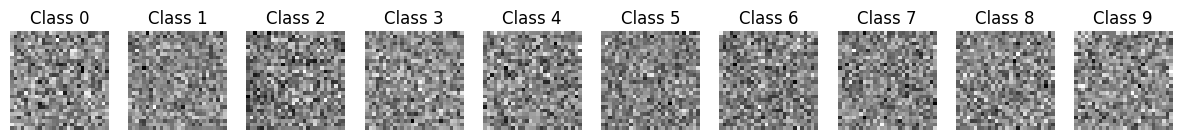

In [8]:
import matplotlib.pyplot as plt
import torch

# Task 1 - Question 2 - Part c

synthetic_data = synthetic_data.detach().cpu()

num_classes = synthetic_data.size(0)

fig, axes = plt.subplots(1, num_classes, figsize=(15, 2))
for i in range(num_classes):
    ax = axes[i]
    ax.imshow(synthetic_data[i].squeeze().numpy(), cmap='gray')
    ax.axis('off')
    ax.set_title(f"Class {i}")

plt.show()


In [9]:
# Task 1 - Question 2 - Part d

import torch
import torch.optim as optim
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

dataset_name = 'MNIST'
data_path = './data'
channel, im_size, num_classes, class_names, mean, std, dst_train, dst_test, test_loader = get_dataset(dataset_name, data_path)

batch_size = 256
real_data_loader = DataLoader(dst_train, batch_size=batch_size, shuffle=True)

mean = 0.0
std = 1.0

synthetic_data = torch.normal(mean=mean, std=std, size=(num_classes, channel, im_size[0], im_size[1]), requires_grad=True, device=device)


model_name = 'ConvNetD3'
model = get_network(model_name, channel, num_classes, im_size).to(device)

K = 100
T = 10
eta_S = 0.1
lambda_param = 0.01

optimizer_syn = optim.SGD([synthetic_data], lr=eta_S)

for k in range(K):
    model.apply(lambda m: m.reset_parameters() if hasattr(m, 'reset_parameters') else None)
    optimizer_model = optim.SGD(model.parameters(), lr=0.01)

    for t in range(T):
        optimizer_syn.zero_grad()
        optimizer_model.zero_grad()

        real_images, real_labels = next(iter(real_data_loader))
        real_images, real_labels = real_images.to(device), real_labels.to(device)

        indices = torch.randperm(real_images.size(0))[:10]
        real_images_subset = real_images[indices]
        real_labels_subset = real_labels[indices]

        outputs_real = model(real_images_subset)
        outputs_syn = model(synthetic_data)

        loss = match_loss(outputs_syn, outputs_real, args) + lambda_param
        loss.backward()
        optimizer_syn.step()

    print(f"Iteration {k + 1}/{K}, SAM Loss: {loss.item()}")

Using device: cpu
Iteration 1/100, SAM Loss: 0.17208893597126007
Iteration 2/100, SAM Loss: 0.5529948472976685
Iteration 3/100, SAM Loss: 0.3486648201942444
Iteration 4/100, SAM Loss: 0.36256349086761475
Iteration 5/100, SAM Loss: 0.2844945192337036
Iteration 6/100, SAM Loss: 0.5611536502838135
Iteration 7/100, SAM Loss: 0.21046508848667145
Iteration 8/100, SAM Loss: 0.3599570393562317
Iteration 9/100, SAM Loss: 0.37686455249786377
Iteration 10/100, SAM Loss: 0.21103163063526154
Iteration 11/100, SAM Loss: 0.5469302535057068
Iteration 12/100, SAM Loss: 0.39416569471359253
Iteration 13/100, SAM Loss: 0.22358949482440948
Iteration 14/100, SAM Loss: 0.42416101694107056
Iteration 15/100, SAM Loss: 0.4253951907157898
Iteration 16/100, SAM Loss: 0.19082404673099518
Iteration 17/100, SAM Loss: 0.34168940782546997
Iteration 18/100, SAM Loss: 0.11208934336900711
Iteration 19/100, SAM Loss: 0.21625222265720367
Iteration 20/100, SAM Loss: 0.18257315456867218
Iteration 21/100, SAM Loss: 0.45799523